Menggunakan dataset Gold Price ( 2013 - 2023 ) yang diambil dari web Kaggle

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
import joblib

In [2]:
np.random.seed(42)

# Load dataset
df = pd.read_csv('Gold Price (2013-2023).csv')
df.head(5)

,Date,Price,Open,High,Low,Vol.,Change %
0,12/30/2022,"1,826.20","1,821.80","1,832.40","1,819.80",107.50K,0.01%
1,12/29/2022,"1,826.00","1,812.30","1,827.30","1,811.20",105.99K,0.56%
2,12/28/2022,"1,815.80","1,822.40","1,822.80","1,804.20",118.08K,-0.40%
3,12/27/2022,"1,823.10","1,808.20","1,841.90","1,808.00",159.62K,0.74%
4,12/26/2022,"1,809.70","1,805.80","1,811.95","1,805.55",NaN,0.30%


In [3]:
# untuk mengecek apakah ada missing values
df.isnull().sum()

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        5
Change %    0
dtype: int64

In [4]:
# Menghapus kolom yang tidak diperlukan
df_clean = df.drop(['Vol.', 'Change %'], axis=1)
df_clean = df_clean.dropna()

In [5]:
# Mengubah kolom 'Date' menjadi tipe datetime
df_clean["Date"] = pd.to_datetime(df_clean["Date"])
df_clean.sort_values(by='Date', ascending=True, inplace=True)
df_clean.reset_index(drop=True, inplace=True)

In [6]:
# Mengubah kolom numerik menjadi float
NumCols = df_clean.columns.drop(['Date'])
df_clean[NumCols] = df_clean[NumCols].replace({',': ''}, regex=True)
df_clean[NumCols] = df_clean[NumCols].astype('float')

In [7]:
# Cek apakah ada duplikasi
df_clean.duplicated().sum()

np.int64(0)

In [8]:
# Cek informasi data
print(df_clean.describe())

                                Date        Price         Open         High  \
count                           2583  2583.000000  2583.000000  2583.000000   
mean   2018-01-02 02:17:08.571428608  1440.326442  1440.646477  1449.639934   
min              2013-01-02 00:00:00  1049.600000  1051.500000  1060.100000   
25%              2015-07-02 12:00:00  1244.200000  1244.350000  1251.600000   
50%              2018-01-03 00:00:00  1320.500000  1320.700000  1326.500000   
75%              2020-07-04 12:00:00  1713.950000  1711.950000  1723.000000   
max              2022-12-30 00:00:00  2058.400000  2065.100000  2078.700000   
std                              NaN   257.338282   257.503397   259.633923   

               Low  
count  2583.000000  
mean   1430.886876  
min    1045.400000  
25%    1236.450000  
50%    1313.200000  
75%    1699.450000  
max    2037.200000  
std     254.753279  


In [9]:
df_clean.head(5)

,Date,Price,Open,High,Low
0,2013-01-02,1689.9,1675.8,1695.0,1672.1
1,2013-01-03,1675.6,1688.0,1689.3,1664.3
2,2013-01-04,1649.9,1664.4,1664.4,1630.0
3,2013-01-07,1647.2,1657.3,1663.8,1645.3
4,2013-01-08,1663.2,1651.5,1662.6,1648.8


<function matplotlib.pyplot.show(close=None, block=None)>

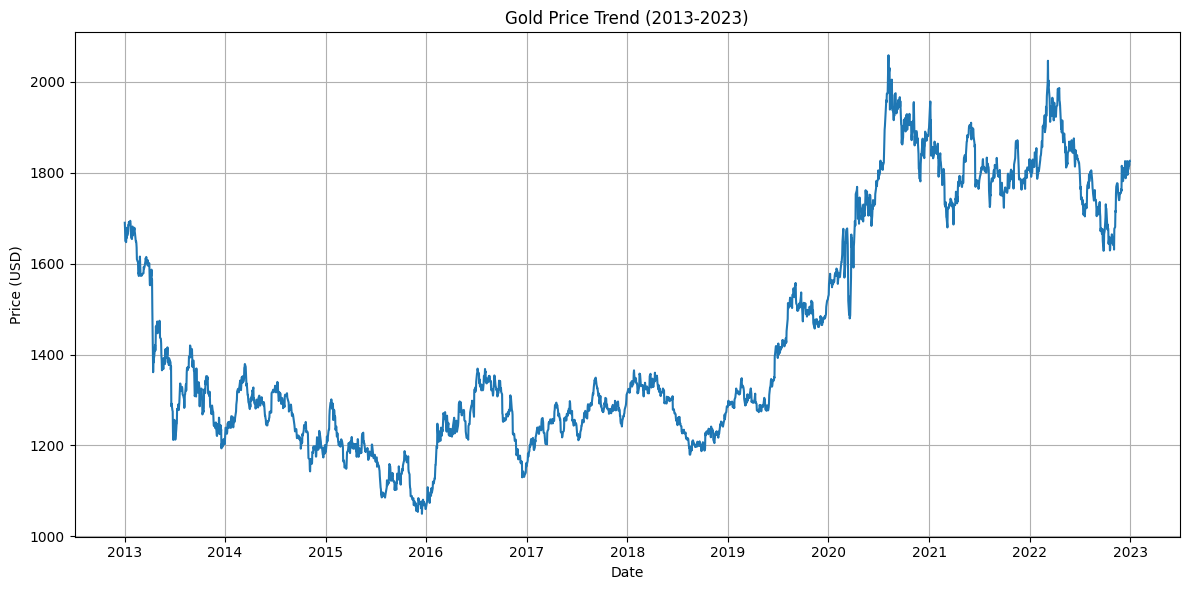

In [10]:
# Exploratory Data Analysis
plt.figure(figsize=(12, 6))
plt.plot(df_clean['Date'], df_clean['Price'])
plt.title('Gold Price Trend (2013-2023)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.tight_layout()
plt.show

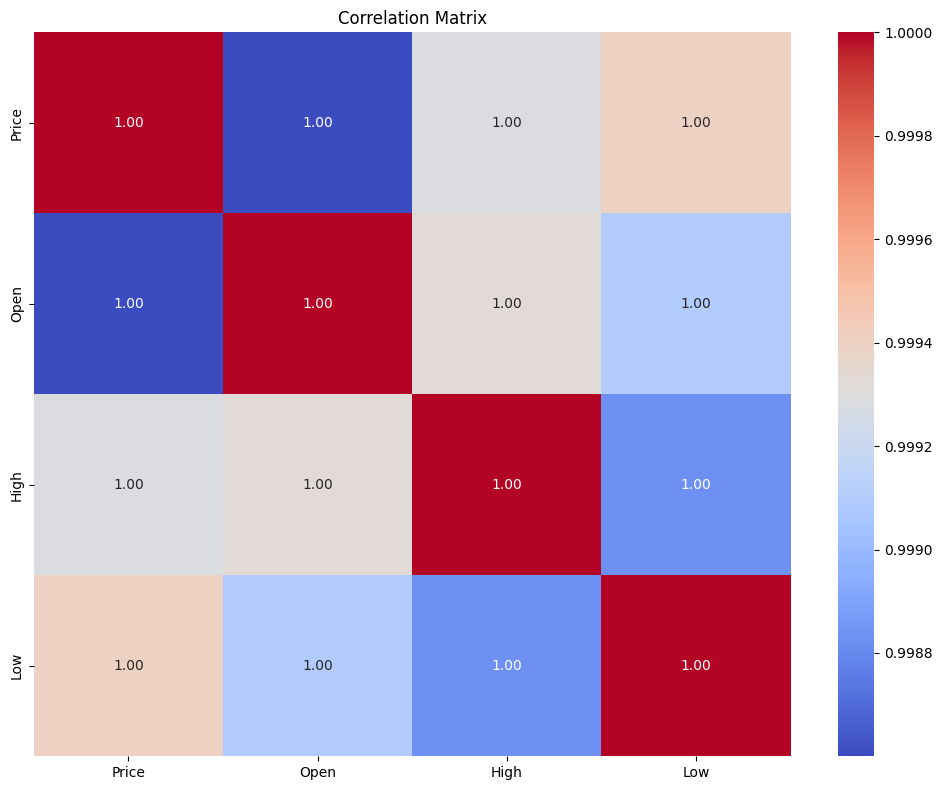

In [11]:
# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df_clean[NumCols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

In [12]:
# Fitur dan Target
selected_features = ['Open', 'High', 'Low']
target = 'Price'

X_raw = df_clean[selected_features]
y_raw = df_clean[[target]]

# Normalisasi terpisah
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw)


In [13]:
# Gabungkan kembali X dan y
data_scaled = np.concatenate((X_scaled, y_scaled), axis=1)

# Buat sequence data
def create_feature_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, :-1])  # semua kolom kecuali terakhir (Price)
        y.append(data[i, -1])                # kolom terakhir sebagai target
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_feature_sequences(data_scaled, seq_length)


In [14]:
# Hanya untuk target
def inverse_transform_target(scaler, y_pred_scaled, y_true_scaled):
    y_pred_inv = scaler.inverse_transform(y_pred_scaled)
    y_true_inv = scaler.inverse_transform(y_true_scaled)
    return y_pred_inv.flatten(), y_true_inv.flatten()


In [15]:
# Split data train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (2018, 60, 3), Test shape: (505, 60, 3)


Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 13s 106ms/step - loss: 0.0148 - val_loss: 0.0061
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - loss: 0.0014 - val_loss: 0.0063
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - loss: 0.0015 - val_loss: 0.0120
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 0.0012 - val_loss: 0.0055
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - loss: 0.0010 - val_loss: 0.0047
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 9.5609e-04 - val_loss: 0.0064
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - loss: 8.6840e-04 - val_loss: 0.0036
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 8.6423e-04 - val_loss: 0.0035
Epoch 9/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 9.7426e-04 - val_loss: 0.0053
Epoch 10/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 8.6882e-04 - val_loss: 0.0062
Epoch 11/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 8.1456e-04 - val_loss: 0.0028
Epoch 12/100
57/57 ━━━━━━

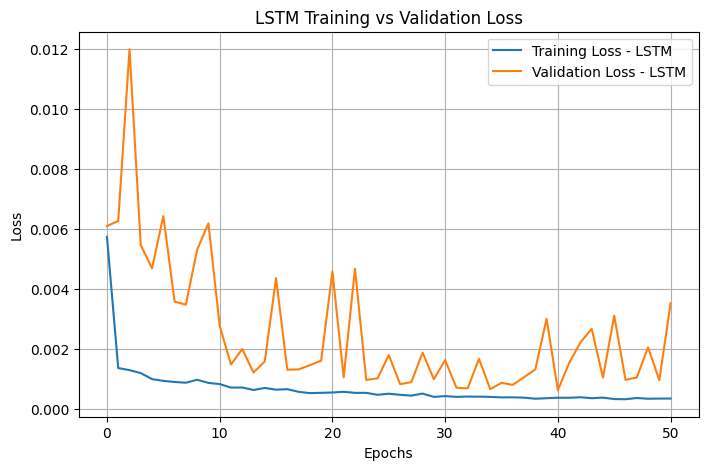

In [16]:
# Model 1: LSTM
input_shape = X_train.shape[1:]

model_lstm = Sequential([
    Input(shape=input_shape),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mse')

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

history_lstm = model_lstm.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

# Prediksi
y_pred_lstm = model_lstm.predict(X_test)

# Visualisasi
plt.figure(figsize=(8, 5))
plt.plot(history_lstm.history['loss'], label='Training Loss - LSTM')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss - LSTM')
plt.title('LSTM Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - loss: 0.0204 - val_loss: 0.0034
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 9.3471e-04 - val_loss: 0.0038
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 8.9884e-04 - val_loss: 0.0023
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - loss: 0.0010 - val_loss: 0.0027
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 7.6011e-04 - val_loss: 0.0025
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - loss: 8.1437e-04 - val_loss: 0.0020
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 6.5376e-04 - val_loss: 0.0024
Epoch 9/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 6.0167e-04 - val_loss: 0.0034
Epoch 10/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - loss: 6.3779e-04 - val_loss: 7.8267e-04
Epoch 11/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 7.9814e-04 - val_loss: 0.0053
Epoch 12/100


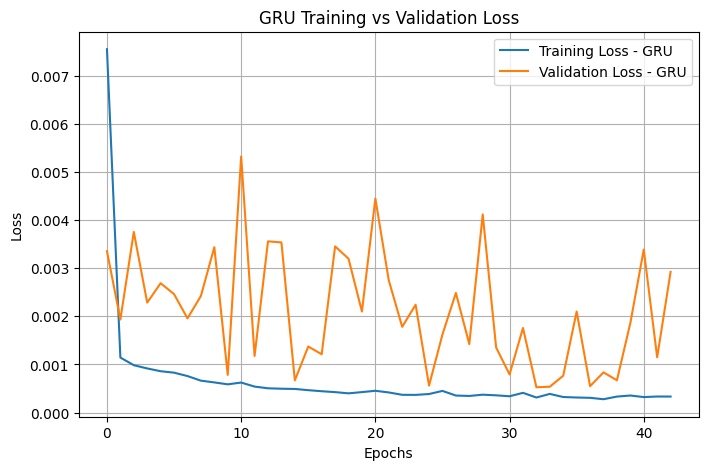

In [17]:
# Model 2: GRU
model_gru = Sequential([
    Input(shape=input_shape),
    GRU(64, return_sequences=True),
    Dropout(0.2),
    GRU(64),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model_gru.compile(optimizer='adam', loss='mse')

history_gru = model_gru.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

# Prediksi
y_pred_gru = model_gru.predict(X_test)

# Visualisasi
plt.figure(figsize=(8, 5))
plt.plot(history_gru.history['loss'], label='Training Loss - GRU')
plt.plot(history_gru.history['val_loss'], label='Validation Loss - GRU')
plt.title('GRU Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [18]:
from statsmodels.tsa.arima.model import ARIMA
#  Model 3: ARIMA
prices_arima = df_clean['Price']
split_arima = int(0.8 * len(prices_arima))
train_arima, test_arima = prices_arima[:split_arima], prices_arima[split_arima:]

# Grid search for optimal ARIMA parameters
best_aic = float('inf')
best_order = None
p_values = range(0, 6)
d_values = range(0, 2)
q_values = range(0, 3)

for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model_arima = ARIMA(train_arima, order=(p, d, q))
                model_arima_fit = model_arima.fit()
                aic = model_arima_fit.aic
                if aic < best_aic:
                    best_aic = aic
                    best_order = (p, d, q)
                    print(f"New best ARIMA order: {best_order} with AIC: {best_aic}")
            except:
                continue

print(f"Best ARIMA order: {best_order}")
model_arima = ARIMA(train_arima, order=best_order)
model_arima_fit = model_arima.fit()
y_pred_arima = model_arima_fit.forecast(steps=len(test_arima))


New best ARIMA order: (0, 0, 0) with AIC: 27785.461211482594
New best ARIMA order: (0, 0, 1) with AIC: 25128.439570730072
New best ARIMA order: (0, 0, 2) with AIC: 23114.05974052001
New best ARIMA order: (0, 1, 0) with AIC: 16753.44289143549


d:\Data Projek\Projek(GoldPrediction)\myenv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Data Projek\Projek(GoldPrediction)\myenv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\Data Projek\Projek(GoldPrediction)\myenv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Data Projek\Projek(GoldPrediction)\myenv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

New best ARIMA order: (4, 1, 0) with AIC: 16753.074027358045
New best ARIMA order: (4, 1, 1) with AIC: 16751.106905413635


d:\Data Projek\Projek(GoldPrediction)\myenv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Data Projek\Projek(GoldPrediction)\myenv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\Data Projek\Projek(GoldPrediction)\myenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Data Projek\Projek(GoldPrediction)\myenv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary

Best ARIMA order: (4, 1, 1)


In [19]:
# Model 4: XGBoost
# Flatten the 3D data for XGBoost
X_xgb = []
y_xgb = []
for i in range(seq_length, len(data_scaled)):
    X_xgb.append(data_scaled[i-seq_length:i, :-1].flatten())
    y_xgb.append(data_scaled[i, -1])

X_xgb = np.array(X_xgb)
y_xgb = np.array(y_xgb)

split_xgb = int(0.8 * len(X_xgb))
X_train_xgb, X_test_xgb = X_xgb[:split_xgb], X_xgb[split_xgb:]
y_train_xgb, y_test_xgb = y_xgb[:split_xgb], y_xgb[split_xgb:]

# Advanced XGBoost
model_xgb = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=1,
    random_state=42
)

model_xgb.fit(X_train_xgb, y_train_xgb)
y_pred_xgb = model_xgb.predict(X_test_xgb)


In [20]:
# Inverse transform predictions
def inverse_transform_preds(scaler, y_pred, y_test):
    # Create a placeholder array for the scaled data
    placeholder = np.zeros((len(y_pred), df_selected.shape[1]))
    
    # Put the predictions in the last column (Price)
    placeholder[:, -1] = y_pred.flatten()
    y_pred_inv = scaler.inverse_transform(placeholder)[:, -1]
    
    # Do the same for y_test
    placeholder[:, -1] = y_test.flatten()
    y_test_inv = scaler.inverse_transform(placeholder)[:, -1]
    
    return y_pred_inv, y_test_inv

# Inverse transform hasil prediksi
y_pred_lstm_inv, y_test_inv = inverse_transform_target(scaler_y, y_pred_lstm, y_test.reshape(-1, 1))
y_pred_gru_inv, _ = inverse_transform_target(scaler_y, y_pred_gru, y_test.reshape(-1, 1))
y_pred_xgb_inv, y_test_xgb_inv = inverse_transform_target(scaler_y, y_pred_xgb.reshape(-1, 1), y_test_xgb.reshape(-1, 1))



In [21]:
# Evaluate all models with MAE, RMSE, and R2
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return {
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    }

metrics_lstm = calculate_metrics(y_test_inv, y_pred_lstm_inv)
metrics_gru = calculate_metrics(y_test_inv, y_pred_gru_inv)
metrics_arima = calculate_metrics(test_arima.values, y_pred_arima)
metrics_xgb = calculate_metrics(y_test_xgb_inv, y_pred_xgb_inv)

In [22]:
# Print results
print("\nModel Evaluation Results:")
print(f"LSTM  -> MAE: {metrics_lstm['MAE']:.2f}, RMSE: {metrics_lstm['RMSE']:.2f}, R2: {metrics_lstm['R2']:.4f}")
print(f"GRU   -> MAE: {metrics_gru['MAE']:.2f}, RMSE: {metrics_gru['RMSE']:.2f}, R2: {metrics_gru['R2']:.4f}")
print(f"ARIMA -> MAE: {metrics_arima['MAE']:.2f}, RMSE: {metrics_arima['RMSE']:.2f}, R2: {metrics_arima['R2']:.4f}")
print(f"XGB   -> MAE: {metrics_xgb['MAE']:.2f}, RMSE: {metrics_xgb['RMSE']:.2f}, R2: {metrics_xgb['R2']:.4f}")


Model Evaluation Results:
LSTM  -> MAE: 14.97, RMSE: 19.53, R2: 0.9286
GRU   -> MAE: 13.72, RMSE: 17.93, R2: 0.9398
ARIMA -> MAE: 142.10, RMSE: 157.58, R2: -3.6410
XGB   -> MAE: 23.23, RMSE: 29.87, R2: 0.8330


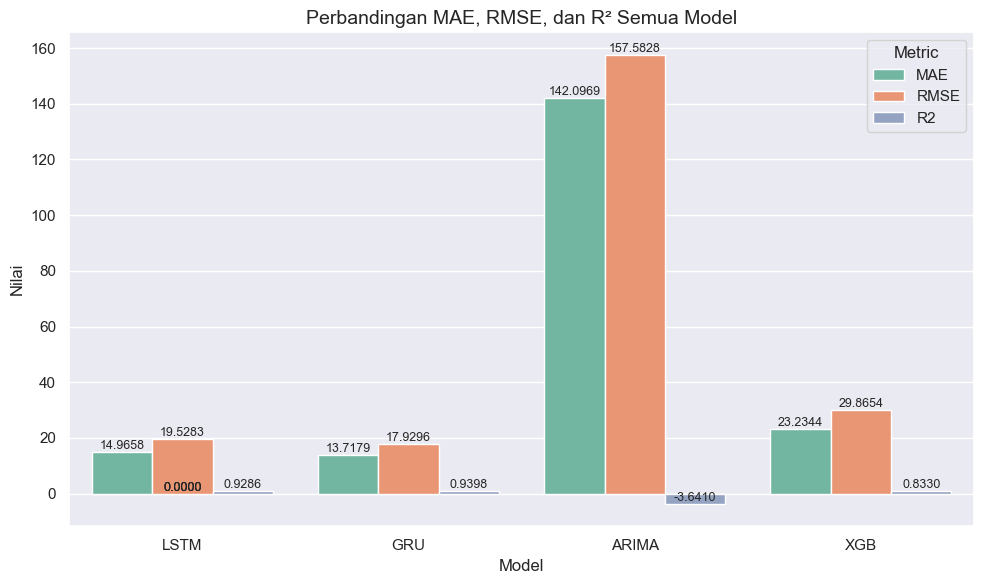

In [31]:
# Data evaluasi model
data = {
    'Model': ['LSTM', 'GRU', 'ARIMA', 'XGB'],
    'MAE': [metrics_lstm['MAE'], metrics_gru['MAE'], metrics_arima['MAE'], metrics_xgb['MAE']],
    'RMSE': [metrics_lstm['RMSE'], metrics_gru['RMSE'], metrics_arima['RMSE'], metrics_xgb['RMSE']],
    'R2': [metrics_lstm['R2'], metrics_gru['R2'], metrics_arima['R2'], metrics_xgb['R2']]
}

# Ubah ke format long agar cocok dengan seaborn
df = pd.DataFrame(data)
df_long = df.melt(id_vars='Model', var_name='Metric', value_name='Value')

# Set style
sns.set(style="darkgrid")

# Buat grouped barplot
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_long, x='Model', y='Value', hue='Metric', palette='Set2')

# Tambahkan label nilai di atas bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.4f}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=9)

# Judul dan layout
plt.title('Perbandingan MAE, RMSE, dan R² Semua Model', fontsize=14)
plt.ylabel('Nilai')
plt.xlabel('Model')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()


In [24]:
# Best model berdasarkan RMSE
models_rmse = {
    'LSTM': metrics_lstm['RMSE'], 
    'GRU': metrics_gru['RMSE'], 
    'ARIMA': metrics_arima['RMSE'], 
    'XGBoost': metrics_xgb['RMSE']
}
best_model = min(models_rmse, key=models_rmse.get)
print(f"\nBest model based on RMSE: {best_model}")


Best model based on RMSE: GRU


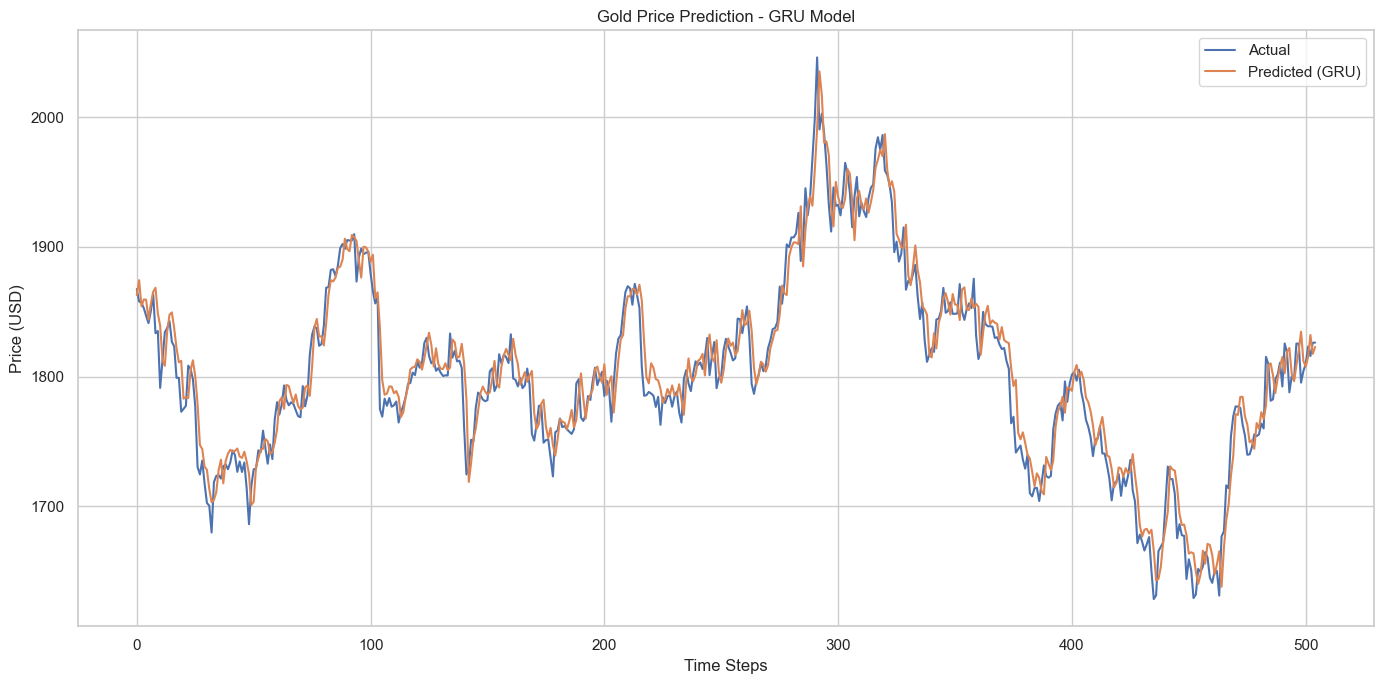

In [25]:
# Plot predictions vs actual for best model
plt.figure(figsize=(14, 7))

if best_model == 'LSTM':
    y_pred_best = y_pred_lstm_inv
elif best_model == 'GRU':
    y_pred_best = y_pred_gru_inv
elif best_model == 'ARIMA':
    y_pred_best = y_pred_arima
    y_test_inv = test_arima.values
else:  # XGBoost
    y_pred_best = y_pred_xgb_inv
    y_test_inv = y_test_xgb_inv

plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_best, label=f'Predicted ({best_model})')
plt.title(f'Gold Price Prediction - {best_model} Model')
plt.xlabel('Time Steps')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [26]:
# Untuk mengsave model
model_gru.save("model_gru.h5")  # menyimpan dalam format HDF5

# Simpan scaler_X
joblib.dump(scaler_X, 'scaler_X.save')

# Simpan scaler_y
joblib.dump(scaler_y, 'scaler_y.save')


['scaler_y.save']